In [1]:
import sys
sys.path.append('../')

import tensorflow as tf
import bargo.datasets as datasets
import bargo.engine as engine
import bargo.utils as utils
import numpy as np
import matplotlib.pyplot as plt

import logging
import pickle

logging.getLogger("tensorflow").setLevel(logging.ERROR)

2024-03-31 16:40:16.207120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


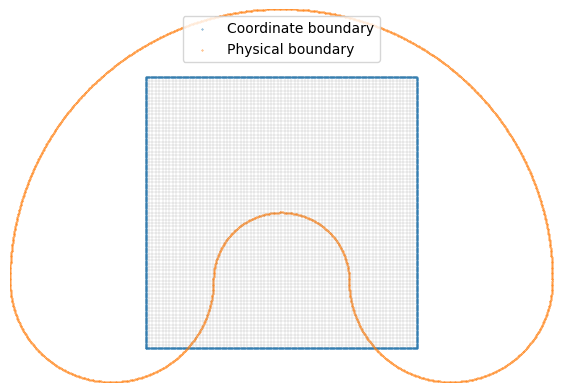

In [2]:
n = 2000
X = datasets.rectangle(n, 2, 2)
# X = datasets.circle(n, 1)
Y = datasets.elephant(n, 2, 0.5)
# Y = datasets.flower(n, 1, 0.2, 5) * 1.2
Y -= Y.mean(axis=0)
grid = {'x0': -1, 'x1': 1, 'dx': 0.025, 'y0': -1, 'y1': 1, 'dy': 0.025}
grid = datasets.flat_grid(**grid)
fig, ax = utils.scatter([('Coordinate boundary', X), ('Physical boundary', Y)], grid, figsize=(7, 7))

In [3]:
N = 10
a = 1
h = 2 * a / (N - 1)

mesh = []
mask = []
for i in range(N):
    for j in range(N):
        x = -a + i * h
        y = -a + j * h
        if not (i==0 or j==0 or i==N-1 or j==N-1):
            mesh.append([x, y])
        mask.append(not (i==0 or j==0 or i==N-1 or j==N-1))

mask = np.reshape(mask, (N, N))
# with open('data/run13/N40/mask.pkl', 'wb') as f:
#     pickle.dump(mask, f)

In [9]:
class abs_leq1(tf.keras.constraints.Constraint):
    def __init__(self, dl) -> None:
        super().__init__()
        self.dl = dl
        pass
    def __call__(self, w):
        while True:
            test_value = self.dl * tf.abs(tf.linalg.trace(w)) + self.dl**2 * tf.abs(tf.linalg.det(w))
            if test_value < 1 - 1e-1:
                return w
            else:
                w = w / 1.1

class geq0(tf.keras.constraints.Constraint):
    def __init__(self, dl) -> None:
        super().__init__()
        self.dl = dl
        pass
    def __call__(self, w):
        if (tf.linalg.trace(w) < 0) or (tf.linalg.det(w) < 0):
            w = tf.abs(w)
            w = w * tf.constant([[1., -1.], [1., 1.]])
        return w
    
class grad(tf.keras.constraints.Constraint):
    def __init__(self, dl, alpha=0.01) -> None:
        super().__init__()
        self.dl = dl
        self.alpha = alpha
        pass

    # def test_f(self, w00, w01, w10, w11):
    #         return 2*self.dl*(tf.abs(w00)+tf.abs(w11))+self.dl**2*(w00*w11-w01*w10)
    # def graf_f(self, w00, w01, w10, w11):
    #     grad00 = 2*self.dl*tf.sign(w00)+self.dl**2*w11
    #     grad01 = -self.dl**2*w10
    #     grad10 = -self.dl**2*w01
    #     grad11 = 2*self.dl*tf.sign(w11)+self.dl**2*w00
    #     return tf.constant([[grad00, grad01], [grad10, grad11]])
    
    def test_f(self, w00, w01, w10, w11):
        dl = self.dl
        detW = w00*w11-w01*w10
        H = (tf.sign(detW) + 1) / 2
        return dl*tf.sqrt(2*tf.square(w00)+2*tf.square(w11))-dl**2*H*detW
    def grad_f(self, w00, w01, w10, w11):
        dl = self.dl
        detW = w00*w11-w01*w10
        H = (tf.sign(detW) + 1) / 2
        grad00 = dl*w00*tf.sqrt(2/(tf.square(w00)+tf.square(w11)))-dl**2*H*w11
        grad01 = self.dl**2*H*w10
        grad10 = self.dl**2*H*w01
        grad11 = dl*w11*tf.sqrt(2/(tf.square(w00)+tf.square(w11)))-dl**2*H*w00
        return tf.Variable([[grad00, grad01], [grad10, grad11]])

    def get_wij(self, w):
        w00 = tf.reduce_sum(w * tf.constant([[1., 0], [0, 0]]))
        w01 = tf.reduce_sum(w * tf.constant([[0, 1.], [0, 0]]))
        w10 = tf.reduce_sum(w * tf.constant([[0, 0], [1., 0]]))
        w11 = tf.reduce_sum(w * tf.constant([[0, 0], [0, 1.]]))
        return w00, w01, w10, w11
    
    def __call__(self, w):
        count = 0
        alpha = self.alpha
        wij = self.get_wij(w)
        while (self.test_f(*wij)) > 0.9:
            if count < 1000:
                w = w - alpha * self.grad_f(*wij)
                wij = self.get_wij(w)
            else:
                w = w / 1.1
                wij = self.get_wij(w)
        return w
        

In [10]:
n_hidden_layers = 10
C = 1
args_hidden = {
    'units': 2,
    'activation': 'tanh',
    'kernel_initializer': 'zeros',
    'bias_initializer': 'zeros',
    'kernel_constraint': grad(1 / n_hidden_layers),
}
model = engine.NN.diffeomorphism(C=C, n_hidden_layers=n_hidden_layers, **args_hidden)

In [11]:
trainer = engine.Trainer(model)
trainer.prepare_data(X, Y, 0.2, 0.2, mesh, grid)

In [12]:
trainer.opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# trainer.loss_fn = engine.CustomLoss(boundary_loss='mse', mesh_loss='winslow', eps=1e-1)
trainer.loss_fn = engine.CustomLoss(boundary_loss='abs_distance')

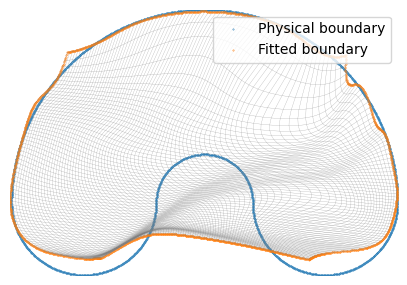

train_loss: 1.6966e-01 val_boundary_loss: 1.4870e-01 eps: 1e+00:   0%|          | 1060/1000000 [04:34<71:46:46,  3.87it/s] 


KeyboardInterrupt: 

In [13]:
trainer.fit(epochs=1000000, patience=1000, val_boundary_loss_target=1e-9, decay_patience=None, plot_step=1000)

from scipy import interpolate

fun = interpolate.LinearNDInterpolator(X, Y)

fun = interpolate.CloughTocher2DInterpolator(X, Y, maxiter=1000, tol=1e-8)

xf = interpolate.interp2d(X[:, 0], X[:, 1], Y[:, 0], kind='cubic')

yf = interpolate.interp2d(X[:, 0], X[:, 1], Y[:, 1], kind='cubic')

deformed_grid = []
for line in grid:
    deformed_grid.append([])
    for pt in line:
        deformed_grid[-1].append([xf(*pt), yf(*pt)])

deformed_grid = []
for line in grid:
    deformed_grid.append(fun(line))

Y_pred = fun(X)

fig, ax = utils.scatter([('Coordinate boundary', Y_pred), ('Physical boundary', Y)], deformed_grid, figsize=(7, 7))

model.save('data/run13/model.keras')

engine.Geometry.push_forward(mesh, 'data/run13/N40')